In [1]:
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

df_path = "/Users/daniels/Documents/CEIA/PACTO/sim_dataset/alunos_based/data/full_dataset.csv"
df = pd.read_csv(df_path)
df

,cliente_codigo,_chave,media_treinos_semanais,tendencia_num_treinos,duracao_media_treinos,pessoa_codigo,foi_indicado,sexo,ano_nascimento,num_convites_enviados,num_convites_recebidos,name,Philanthropist,Socialiser,Achiever,Player,Free Spirit,Disruptor,pred_dominant_hexad,pred_secondary_hexad
0,7459.0,28359f7fc700f9b9904a3b619c84022c,2.076923,-0.029541,88.421974,112303,False,1,1983,0.0,0.0,João Almeida,6.0,6.0,7.0,7.0,6.0,5.0,Achiever,Player
1,7459.0,28359f7fc700f9b9904a3b619c84022c,2.076923,-0.029541,88.421974,112303,False,1,1983,0.0,0.0,João Almeida,5.0,6.0,7.0,7.0,6.0,3.0,Achiever,Player
2,7326.0,ef9f2365f60ac8e2356e254c8c91488f,2.421053,0.058255,62.634316,8100,False,-1,1993,0.0,0.0,Clara Silva,7.0,7.0,6.0,5.0,6.0,3.0,Philanthropist,Socialiser
3,7326.0,ef9f2365f60ac8e2356e254c8c91488f,2.421053,0.058255,62.634316,8100,False,-1,1993,0.0,0.0,Clara Silva,7.0,7.0,6.0,5.0,6.0,2.5,Philanthropist,Socialiser
4,5062.0,ca13bee745eaeffb2c494385eeec9a47,2.120000,-0.074332,60.365232,21528,False,1,1989,0.0,0.0,Carlos Menezes,7.0,6.0,6.5,6.0,6.0,2.5,Philanthropist,Achiever
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
145,5543.0,ef9f2365f60ac8e2356e254c8c91488f,2.095238,0.005602,44.813269,6213,False,1,1997,0.0,0.0,Carlos,6.0,5.0,7.0,6.0,7.0,4.0,Achiever,Free Spirit
146,14657.0,1d40882bc4bd32e41d71d18381755f93,2.360000,0.013077,67.948483,119546,False,1,1995,0.0,0.0,Lucas Almeida,6.0,4.0,7.0,5.5,7.0,4.0,Achiever,Free Spirit
147,10856.0,33fa79e54690bc45beb83343f7e3c730,1.500000,-0.285714,57.864115,11222,False,1,2007,0.0,0.0,Rodrigo,6.0,4.0,7.0,7.0,6.0,2.5,Achiever,Player
148,11254.0,a855c5c74458a07ac7301a1a8df5b7ed,3.000000,1.500000,107.035579,11808,False,-1,1978,0.0,0.0,Laura Valente,6.0,3.0,7.0,6.0,7.0,5.5,Achiever,Free Spirit


In [2]:
# Renomeia as colunas para lowercase e troca espacos por underline
df.columns = df.columns.str.lower().str.replace(' ', '_')

In [3]:
def simulate_multi_labels(df: pd.DataFrame,
                          n_classes: int,
                          min_labels: int = 1,
                          max_labels: int = 5,
                          seed: int = 42,
                          prefix: str = 'desafio_'
                          ) -> pd.DataFrame:
    """
    Para cada linha de df, sorteia entre min_labels e max_labels IDs únicos
    em [0, n_classes), e preenche:
      - df['desafios_feitos']: lista de IDs
      - colunas df['ch_0'], ..., df['ch_{n_classes-1}']: 0/1 multi-hot
    """
    np.random.seed(seed)
    all_done = []
    # sortear conjuntos de desafios
    for _ in range(len(df)):
        k = np.random.randint(min_labels, max_labels+1)
        chosen = np.random.choice(n_classes, size=k, replace=False).tolist()
        all_done.append(chosen)
    df = df.copy()
    df['desafios_feitos'] = all_done

    labels_cols = [f'{prefix}{i}' for i in range(n_classes)]
    # construir vetores multi-hot
    for c in range(n_classes):
        df[labels_cols[c]] = df['desafios_feitos'].apply(lambda lst: 1 if c in lst else 0)

    return df.drop(columns=['desafios_feitos']), labels_cols

n_classes = 10
prefix = 'desafio_'
df, labels_cols = simulate_multi_labels(df, n_classes, min_labels=1, max_labels=4, prefix=prefix)

## Pré processamento

In [4]:
# One-hot encode do sexo(1, -1 e 0) com get_dummies
df = pd.get_dummies(df, columns=["sexo"])

# Converte a coluna 'foi_indicado' para 0/1
df['foi_indicado'] = df['foi_indicado'].astype(float)

# Train Val split
df_train, df_val = train_test_split(df, test_size=0.3, random_state=42)

# 2) Lista de colunas numéricas
numeric_cols = [
    'media_treinos_semanais',
    'tendencia_num_treinos',
    'duracao_media_treinos',
    'ano_nascimento',
    'num_convites_enviados',
    'num_convites_recebidos',
    'philanthropist',
    'socialiser',
    'achiever',
    'player',
    'free_spirit',
    'disruptor',
]

# Ajusta o scaler no treino
scaler = StandardScaler()
scaler.fit(df_train[numeric_cols])

# Aplica transformação em todos os splits
df_train[numeric_cols] = scaler.transform(df_train[numeric_cols])
df_val[numeric_cols] = scaler.transform(df_val[numeric_cols])

In [5]:
class DatasetAluno(Dataset):
    def __init__(
            self,
            dataframe: pd.DataFrame,
            input_cols: list,
            labels_cols: list,
            transforms=None
    ):
        self.dataframe = dataframe.reset_index(drop=True)
        self.transforms = transforms
        self.input_cols = input_cols
        self.labels_cols = labels_cols

    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        row = self.dataframe.iloc[idx]
        x = torch.tensor(row[self.input_cols].to_numpy(dtype=np.float32), dtype=torch.float32)
        y = torch.tensor(row[self.labels_cols].to_numpy(dtype=np.float32), dtype=torch.float32)
        
        if self.transforms:
            x = self.transforms(x)
        
        return x, y
    
fks = ["cliente_codigo", "_chave", "pessoa_codigo", "name", "pred_dominant_hexad", "pred_secondary_hexad"]
input_cols = [col for col in df.columns if col not in labels_cols + fks]
train_dataset = DatasetAluno(df_train, input_cols, labels_cols)
val_dataset = DatasetAluno(df_val, input_cols, labels_cols)

## Model

In [ ]:
class RecSys(nn.Module):
    def __init__(
            self,
            input_dim: int,
            output_dim: int,
            hidden_dims: list[int] = [128, 64],
            dropout: float = 0.2
    ):
        super(RecSys, self).__init__()
        self.input_dim = input_dim
        self.output_dim = output_dim
        
        h1, h2 = hidden_dims

        # Camada de entrada
        self.fc1 = nn.Linear(input_dim, h1)
        self.bn1 = nn.BatchNorm1d(h1)
        self.drop1 = nn.Dropout(dropout)

        # Camada oculta
        self.fc2 = nn.Linear(h1, h2)
        self.bn2 = nn.BatchNorm1d(h2)
        self.drop2 = nn.Dropout(dropout)

        # Camada de saída
        self.output = nn.Linear(h2, output_dim)


    def forward(self, x):
        # Passa pela primeira camada
        x = self.fc1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.drop1(x)

        # Passa pela segunda camada
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.drop2(x)

        # Passa pela camada de saída
        logits = self.output(x)
        probs = torch.sigmoid(logits)
        return probs

In [ ]:
# Definindo o modelo
model = RecSys(
    input_dim=len(input_cols),
    output_dim=len(labels_cols),
    hidden_dims=[128, 64],
    dropout=0.2
)

device = torch.device("mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Definindo o otimizador e a função de perda
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.BCEWithLogitsLoss()

# Definindo o DataLoader
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
# Treinamento
num_epochs = 20

epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for x_batch, y_batch in tqdm(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        
        # Zera os gradientes
        optimizer.zero_grad()
        
        # Forward pass
        y_hat_batch = model(x_batch)
        
        # Calcula a perda
        loss = criterion(y_hat_batch, y_batch)

        # Backward pass
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader.dataset)
    epoch_losses.append(epoch_loss)
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}")

    # Validação
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for x_batch, y_batch in val_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_hat_batch = model(x_batch)
            loss = criterion(y_hat_batch, y_batch)
            val_loss += loss.item()

    val_loss /= len(val_loader.dataset)
    print(f"Validation Loss: {val_loss:.4f}")    

100%|██████████| 4/4 [00:00<00:00,  5.36it/s]


Epoch 1/20, Loss: 0.0321
Validation Loss: 0.0373


100%|██████████| 4/4 [00:00<00:00, 56.28it/s]


Epoch 2/20, Loss: 0.0317
Validation Loss: 0.0371


100%|██████████| 4/4 [00:00<00:00, 82.02it/s]


Epoch 3/20, Loss: 0.0310
Validation Loss: 0.0369


100%|██████████| 4/4 [00:00<00:00, 74.42it/s]


Epoch 4/20, Loss: 0.0309
Validation Loss: 0.0366


100%|██████████| 4/4 [00:00<00:00, 61.80it/s]


Epoch 5/20, Loss: 0.0306
Validation Loss: 0.0362


100%|██████████| 4/4 [00:00<00:00, 87.44it/s]


Epoch 6/20, Loss: 0.0303
Validation Loss: 0.0359


100%|██████████| 4/4 [00:00<00:00, 84.16it/s]


Epoch 7/20, Loss: 0.0299
Validation Loss: 0.0355


100%|██████████| 4/4 [00:00<00:00, 92.82it/s]


Epoch 8/20, Loss: 0.0298
Validation Loss: 0.0351


100%|██████████| 4/4 [00:00<00:00, 86.97it/s]


Epoch 9/20, Loss: 0.0293
Validation Loss: 0.0348


100%|██████████| 4/4 [00:00<00:00, 75.68it/s]


Epoch 10/20, Loss: 0.0291
Validation Loss: 0.0346


100%|██████████| 4/4 [00:00<00:00, 59.98it/s]


Epoch 11/20, Loss: 0.0291
Validation Loss: 0.0344


100%|██████████| 4/4 [00:00<00:00, 61.15it/s]


Epoch 12/20, Loss: 0.0288
Validation Loss: 0.0342


100%|██████████| 4/4 [00:00<00:00, 73.39it/s]


Epoch 13/20, Loss: 0.0286
Validation Loss: 0.0339


100%|██████████| 4/4 [00:00<00:00, 83.09it/s]


Epoch 14/20, Loss: 0.0285
Validation Loss: 0.0338


100%|██████████| 4/4 [00:00<00:00, 114.87it/s]


Epoch 15/20, Loss: 0.0283
Validation Loss: 0.0336


100%|██████████| 4/4 [00:00<00:00, 122.12it/s]


Epoch 16/20, Loss: 0.0280
Validation Loss: 0.0335


100%|██████████| 4/4 [00:00<00:00, 116.03it/s]


Epoch 17/20, Loss: 0.0279
Validation Loss: 0.0333


100%|██████████| 4/4 [00:00<00:00, 122.28it/s]


Epoch 18/20, Loss: 0.0277
Validation Loss: 0.0331


100%|██████████| 4/4 [00:00<00:00, 106.79it/s]


Epoch 19/20, Loss: 0.0276
Validation Loss: 0.0330


100%|██████████| 4/4 [00:00<00:00, 92.82it/s]


Epoch 20/20, Loss: 0.0277
Validation Loss: 0.0329


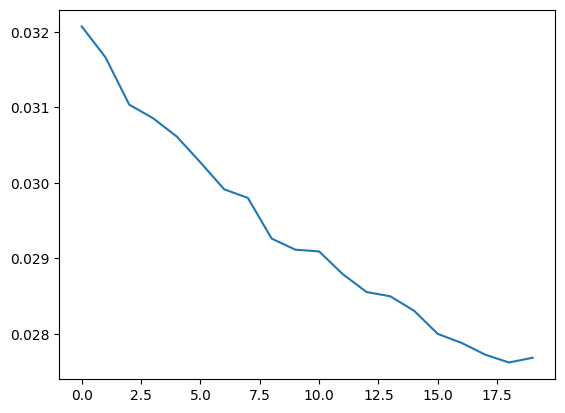

In [ ]:
# Plotando a perda
plt.plot(epoch_losses)